In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
cd /content/drive/MyDrive/TWITTER_RESULTS

/content/drive/MyDrive/TWITTER_RESULTS


# **Parameters Setting**

In [ ]:
maxlen = 130
latent_dim = 26
manifold_dim = 10
epochs = 100

In [ ]:
from importlib import reload
import sys
import pandas as pd
import numpy as np
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

In [ ]:
df = pd.read_csv('twitter.csv')
df.columns = ['id','sentiment','review']
df.head()

,id,sentiment,review
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df['sentiment'].value_counts()


sentiment
0    29720
1     2242
Name: count, dtype: int64

In [ ]:


pos = []
neg = []
for i in range(len(df)):
  if df['sentiment'][i] == 1:
    pos.append(df['review'][i])
  else:
    neg.append(df['review'][i])
new = neg[:len(pos)]

plus = [1 for i in range(len(new))]
minus = [0 for i in range(len(new))]

df1 = pd.DataFrame(pos, columns=['review'])
df2 = pd.DataFrame(new, columns=['review'])

df1['label'] = plus
df2['label'] = minus

df = pd.concat([df1,df2])
df.tail()

,review,label
2237,found my future husband on the plane to marbs ...,0
2238,", excited, clapping, unbreakable kimmy schmid...",0
2239,not long until the england v wales match! the ...,0
2240,nude rear naughty naked school girls,0
2241,"""uk now has the highest average level of stude...",0


In [ ]:
np.unique(df['label'])

array([0, 1])

In [ ]:
df = df.dropna()

# **Text Preprocessing**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = str(text)
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\s+',' ',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('$', '', text)
    text = re.sub('@', '', text)
    text = re.sub('#', '', text)
    text = re.sub('!', '', text)
    text = re.sub('%', '', text)
    text = re.sub('&', '', text)
    text = re.sub('-', '', text)
    text = re.sub('ð', '', text)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
def lem(text):
  words = word_tokenize(text)
  wrd = []
  ps = PorterStemmer()
  for w in words:
    rootWord=ps.stem(w)
    wrd.append(rootWord)
  return ' '.join(wrd)

In [ ]:
df['Processed_Reviews'] = df.Processed_Reviews.apply(lambda x: lem(x))

In [ ]:
df.head()

,review,label,Processed_Reviews
0,@user #cnn calls #michigan middle school 'buil...,1,user cnn call michigan middl school build wall...
1,no comment! in #australia #opkillingbay #se...,1,comment australia opkillingbay seashepherd hel...
2,retweet if you agree!,1,retweet agre
3,@user @user lumpy says i am a . prove it lumpy.,1,user user lumpi say prove lumpi
4,it's unbelievable that in the 21st century we'...,1,unbeliev 21st centuri wed need someth like nev...


In [ ]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

8.969669937555754

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Processed_Reviews'],df['label'],
                                                    test_size = 0.2, shuffle =  True, random_state = 42)

# **Text Embedding**

In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

x_train = word_tokenizer.texts_to_sequences(x_train)
x_test = word_tokenizer.texts_to_sequences(x_test)
x_train= pad_sequences(x_train, padding='post',maxlen=maxlen)
x_test= pad_sequences(x_test, padding='post',maxlen=maxlen)

vocab_length = len(word_tokenizer.word_index)+1
vocab_length

8263

# **Solve class imbalanced**

In [ ]:
from collections import Counter
Counter(y_train)

Counter({1: 1799, 0: 1788})

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

oversample = RandomOverSampler(sampling_strategy=1)

x_train, y_train = oversample.fit_resample(x_train, y_train)
x_test, y_test = oversample.fit_resample(x_test, y_test)
Counter(y_train)

Counter({1: 1799, 0: 1799})

In [ ]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


embedding_matrix.shape

(8263, 300)

In [ ]:
!pip install -q keras-self-attention

  Preparing metadata (setup.py) ... done


# **Global Dimention Reduction with Trasformers**

In [ ]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D,LayerNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import keras
from keras_self_attention  import SeqSelfAttention # Self attention

input = Input(shape=(maxlen,))
x = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=True)(input)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = SeqSelfAttention(units = 128, attention_width= 10,
                           attention_type = SeqSelfAttention.ATTENTION_TYPE_MUL,
                           return_attention = False,
                           kernel_initializer = 'glorot_normal', bias_initializer= 'zeros',
                           kernel_regularizer = None, bias_regularizer = None,
                           kernel_constraint= None, bias_constraint= None,
                           use_additive_bias= True,
                           use_attention_bias = True, attention_activation = 'relu',
                           attention_regularizer_weight = 0)(x)
x = GlobalMaxPool1D()(x)
x = Dense(latent_dim, activation="relu")(x)
bottleneck = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(bottleneck)

model = keras.Model(inputs=input, outputs=output)
encoder = Model(inputs = model.input, outputs = bottleneck)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
history = model.fit(x_train,y_train, batch_size=maxlen, epochs=100, validation_split=0.2,callbacks = [callback])

Epoch 1/100
23/23 [==============================] - 11s 224ms/step - loss: 0.5810 - accuracy: 0.7290 - val_loss: 0.5166 - val_accuracy: 0.7764
Epoch 2/100
23/23 [==============================] - 3s 155ms/step - loss: 0.4209 - accuracy: 0.8221 - val_loss: 0.3808 - val_accuracy: 0.8431
Epoch 3/100
23/23 [==============================] - 3s 117ms/step - loss: 0.3034 - accuracy: 0.8846 - val_loss: 0.3501 - val_accuracy: 0.8597
Epoch 4/100
23/23 [==============================] - 3s 115ms/step - loss: 0.1896 - accuracy: 0.9329 - val_loss: 0.3353 - val_accuracy: 0.8639
Epoch 5/100
23/23 [==============================] - 2s 100ms/step - loss: 0.1127 - accuracy: 0.9625 - val_loss: 0.3816 - val_accuracy: 0.8653


# **Summary of deep model (Trainable and NonTrainable parameters)**

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130)]             0         
                                                                 
 embedding (Embedding)       (None, 130, 300)          2478900   
                                                                 
 bidirectional (Bidirection  (None, 130, 256)          439296    
 al)                                                             
                                                                 
 seq_self_attention (SeqSel  (None, 130, 256)          65537     
 fAttention)                                                     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                             

# **Convergence behavir of the Encoder-Decoder model**

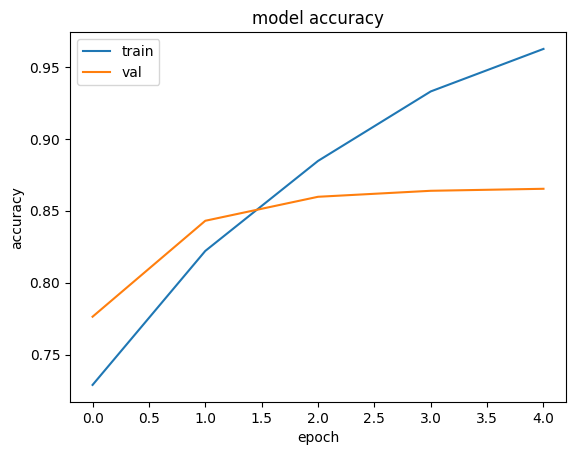

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

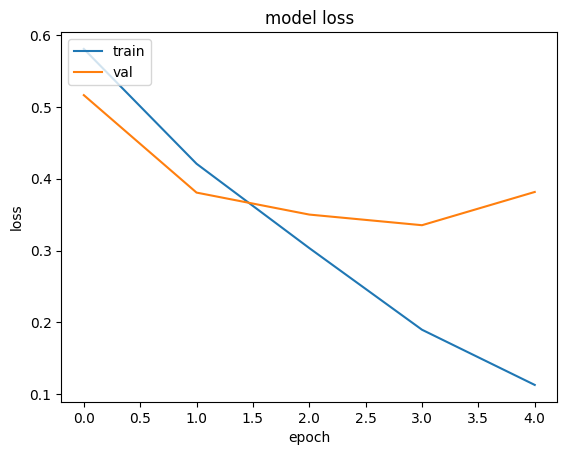

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Plot the structure of the encoder model**

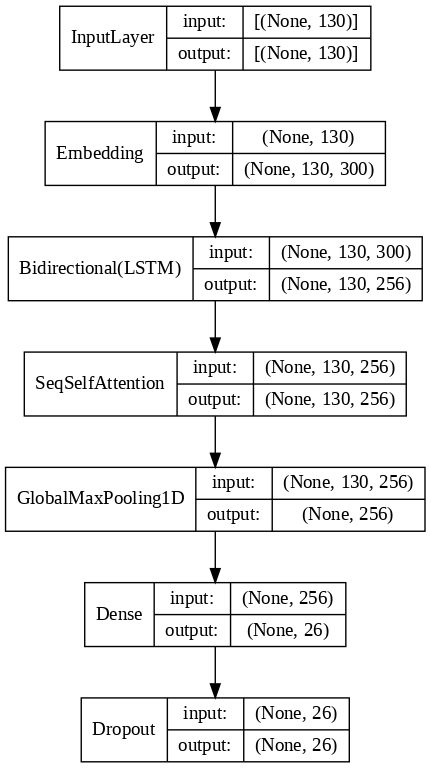

In [ ]:
keras.utils.plot_model(
    encoder,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False,
)

In [ ]:
x_encoded_train = encoder.predict(x_train)
x_encoded_test = encoder.predict(x_test)
print(x_encoded_train.shape, x_encoded_test.shape)

29/29 [==============================] - 0s 5ms/step
(3598, 26) (908, 26)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
 f1_score, confusion_matrix, classification_report)

# **Results over LM model**

# **Results of the ISomap model**

--------------------------Results for manifold dimention-------------------
Accuracy: 0.12665198237885464
Precision: 0.11910112359550562
Recall: 0.11674008810572688
F1 score: 0.11790878754171301
              precision    recall  f1-score   support

           0       0.13      0.14      0.14       454
           1       0.12      0.12      0.12       454

    accuracy                           0.13       908
   macro avg       0.13      0.13      0.13       908
weighted avg       0.13      0.13      0.13       908

--------------------------Results for 3d dimention -------------------
Accuracy: 0.13656387665198239
Precision: 0.10144927536231885
Recall: 0.09251101321585903
F1 score: 0.09677419354838711
              precision    recall  f1-score   support

           0       0.17      0.18      0.17       454
           1       0.10      0.09      0.10       454

    accuracy                           0.14       908
   macro avg       0.13      0.14      0.13       908
weighted avg    

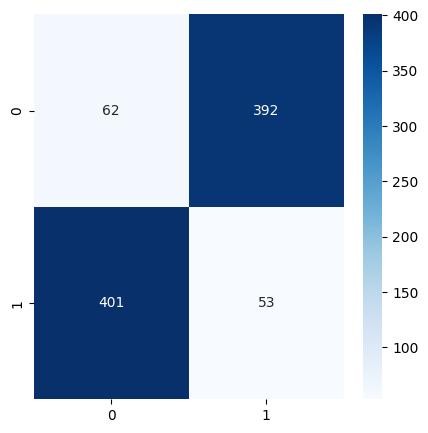

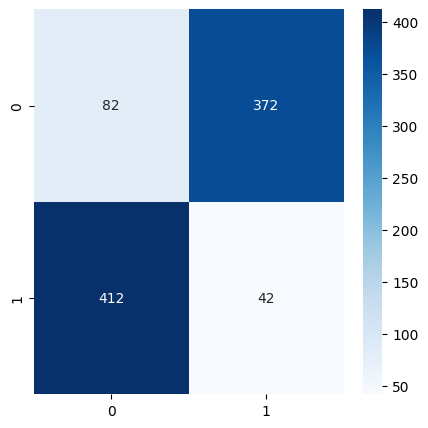

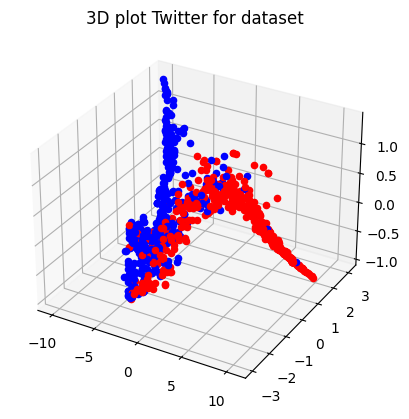

In [ ]:
 from sklearn.manifold import Isomap
manifold_dim = 10
x_new_train = Isomap(n_components = manifold_dim,
                           metric = "euclidean",
                           n_neighbors = 50).fit_transform(x_encoded_train)

x_new_test = Isomap(n_components = manifold_dim,
                           metric = "euclidean",
                           n_neighbors = 50).fit_transform(x_encoded_test)

print('--------------------------Results for manifold dimention-------------------')

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

x_new_train = Isomap(n_components = 3,
                           metric = "euclidean",
                           n_neighbors = 50).fit_transform(x_encoded_train)

x_new_test = Isomap(n_components = 3,
                           metric = "euclidean",
                           n_neighbors = 50).fit_transform(x_encoded_test)

print('--------------------------Results for 3d dimention -------------------')
model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')
y_test = np.array(y_test)
fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in range(len(y_test)):
    ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
    ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
ax.set_title('3D plot Twitter for dataset')
plt.show()